# Importar librerias

In [1]:
import janitor
import nhanes.load
import numpy as np
import pandas as pd
import missingno

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\nhanes\load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pkg_resources\__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pkg_resources\__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_res

## Importar funciones personalizadas

In [2]:
%run pandas-missing-extension.ipynb

## Cargar los datos de NHANES

In [3]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year="2017-2018")
nhanes_raw_df

,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,TypeOfMilkFirstFed1Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


In [4]:
missing_values = nhanes_raw_df.isna().sum()
print(missing_values)

GeneralHealthCondition                 2402
EverBreastfedOrFedBreastmilk           7297
AgeStoppedBreastfeedingdays            7504
AgeFirstFedFormuladays                 7289
AgeStoppedReceivingFormuladays         7475
                                       ... 
UnitOfMeasureDayweekmonthyear_2_SMQ    7870
CurrentSelfreportedHeightInches        2590
CurrentSelfreportedWeightPounds        2538
TriedToLoseWeightInPastYear            3279
TimesLost10LbsOrMoreToLoseWeight       2572
Length: 197, dtype: int64


## Procesar los datos de NHANES

In [5]:
nhanes_df = (
    nhanes_raw_df.select_columns(
        "GeneralHealthCondition",
        "AgeInYearsAtScreening",
        "Gender",
        "CurrentSelfreportedHeightInches",
        "CurrentSelfreportedWeightPounds",
        "DoctorToldYouHaveDiabetes",
        "60SecPulse30SecPulse2",
        "TotalCholesterolMgdl"
    )
    .rename_columns(
        {
            "AgeInYearsAtScreening":"age",
            "CurrentSelfreportedHeightInches":"height",
            "CurrentSelfreportedWeightPounds":"weight",
            "DoctorToldYouHaveDiabetes":"diabetes",
            "60SecPulse30SecPulse2":"pulse",
            "TotalCholesterolMgdl":"total_cholesterol"
        }
    )
    .replace(
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


In [6]:
nhanes_df

,height,weight,GeneralHealthCondition,total_cholesterol,pulse,diabetes,Gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


## Visualizar los valores faltantes

<Axes: >

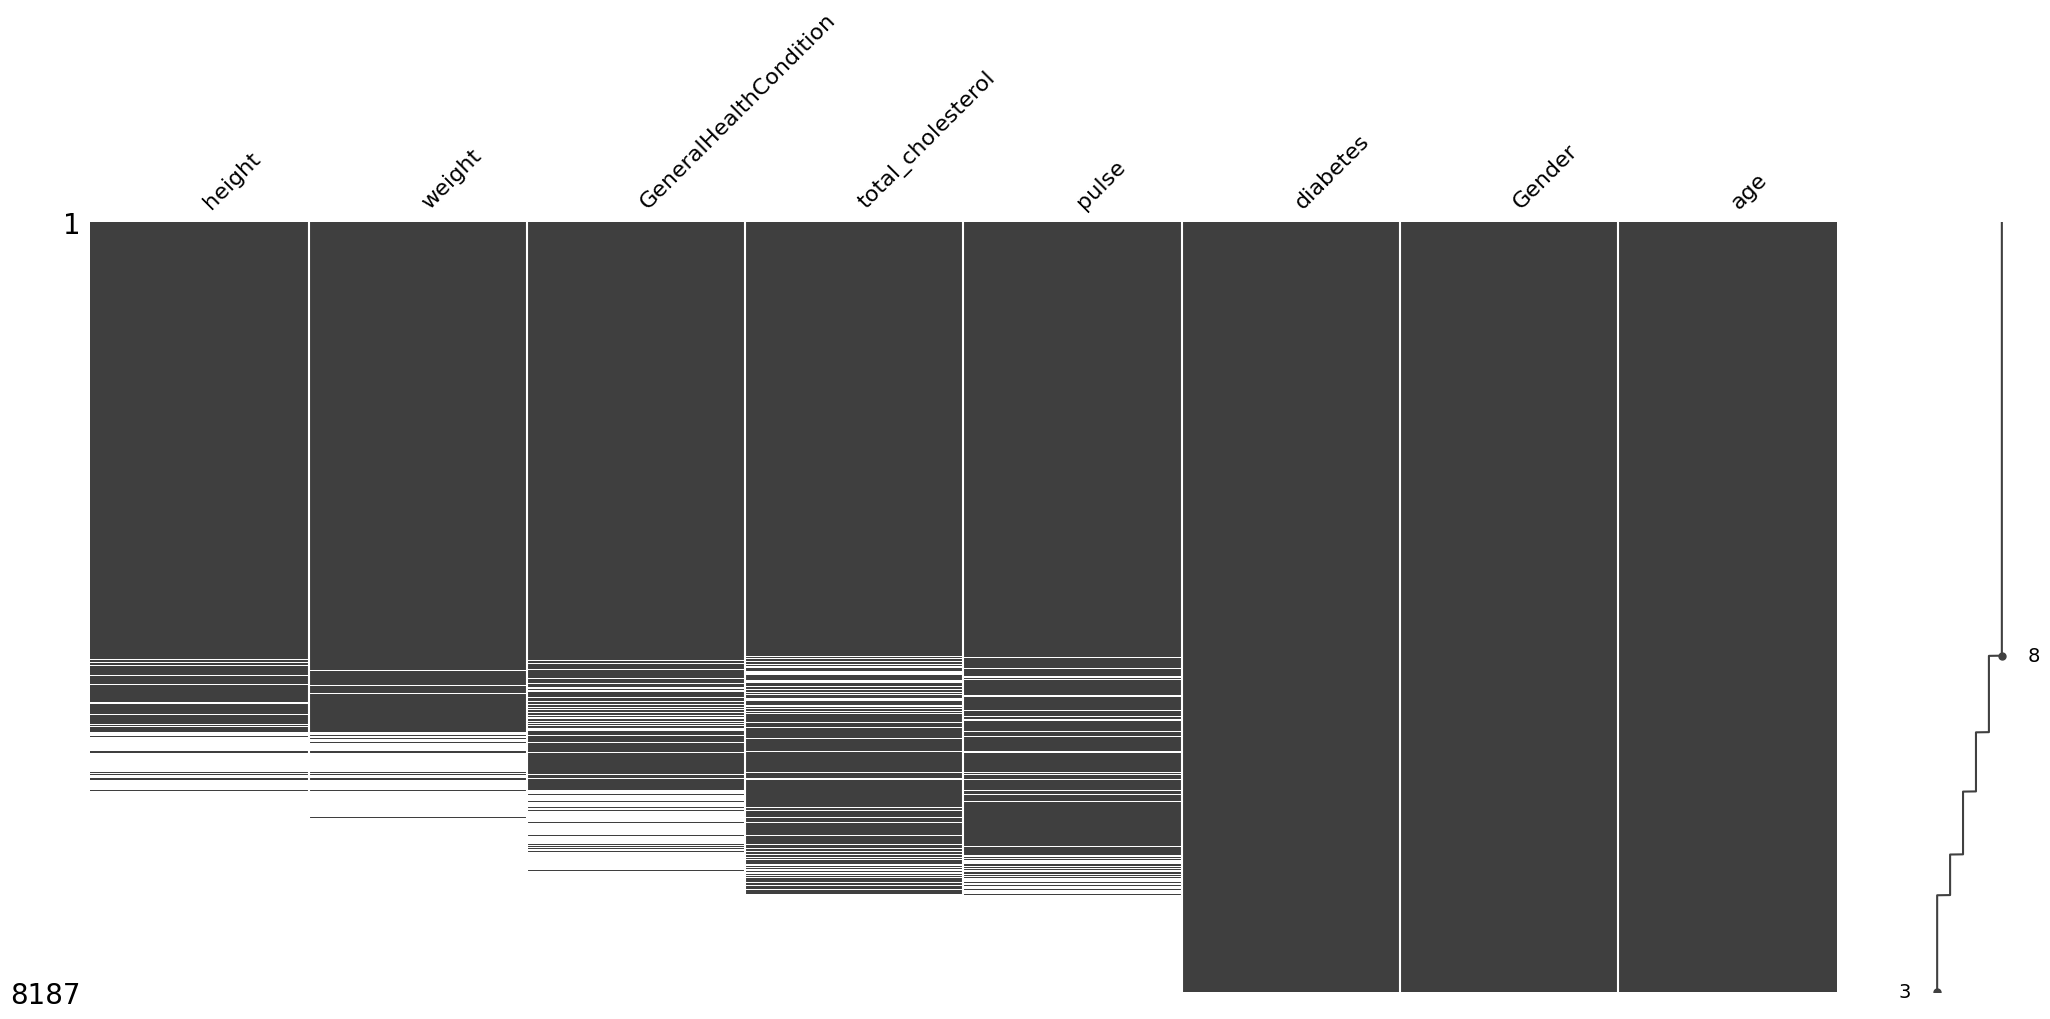

In [11]:
nhanes_df.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort="descending")

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

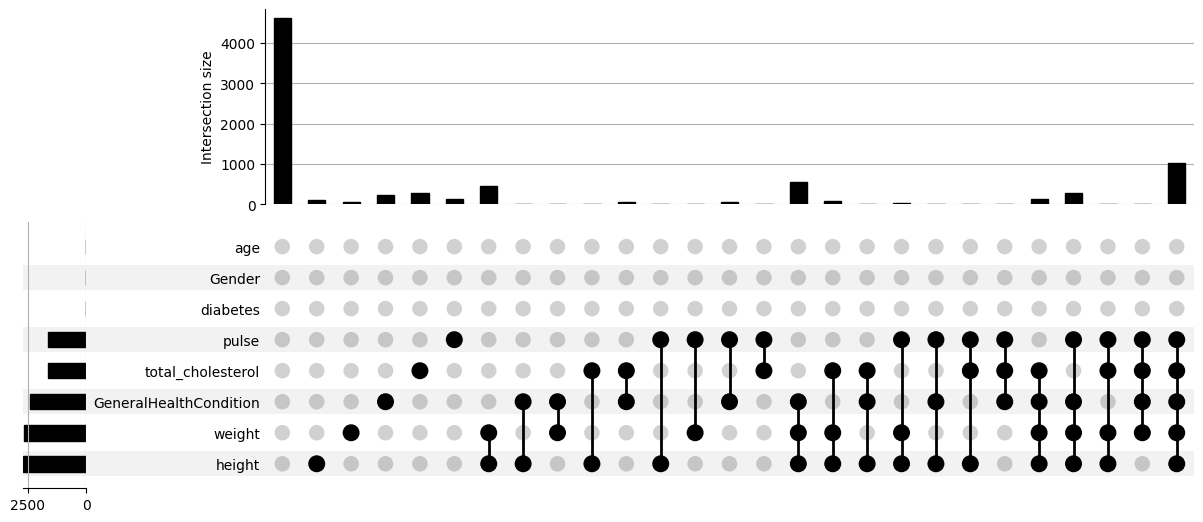

In [13]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()        
)

<Axes: >

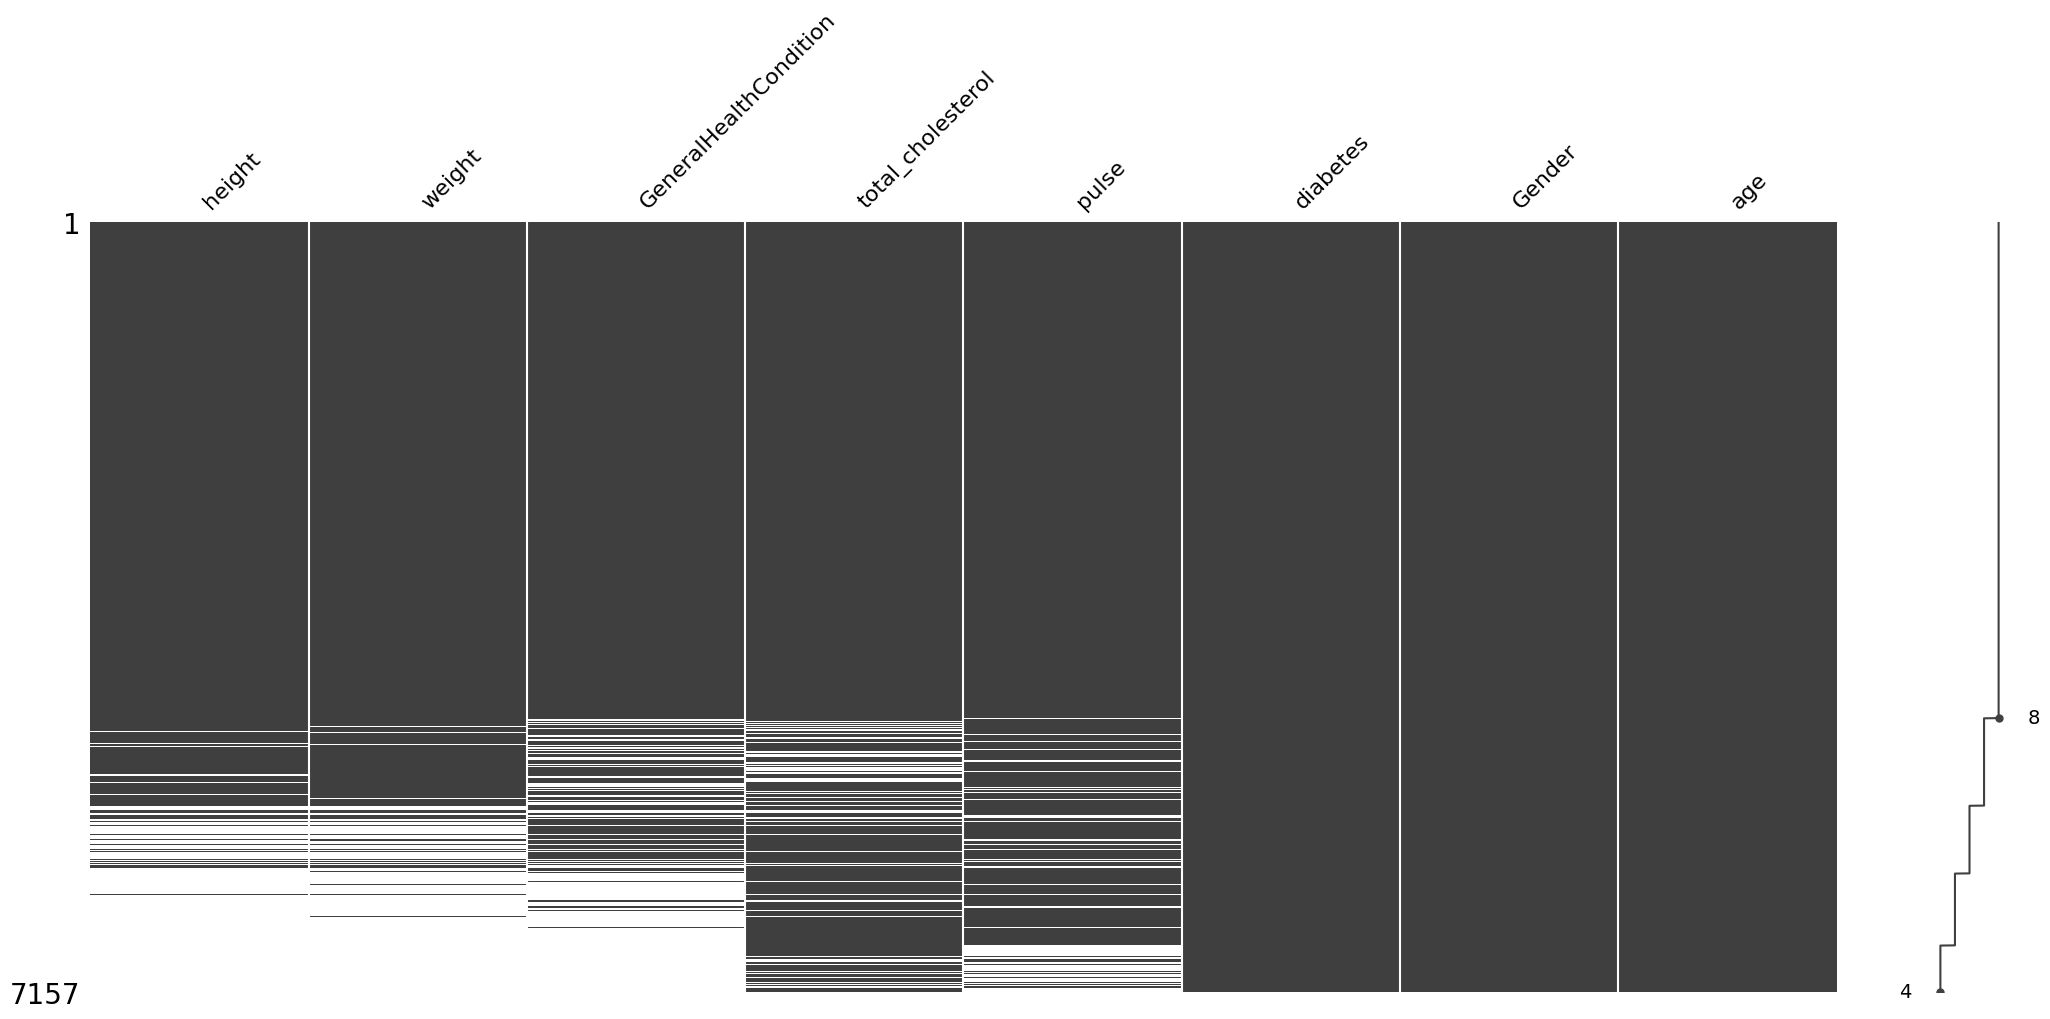

In [18]:
(
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "GeneralHealthCondition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort="descending")
)

## Eliminar valores faltantes

In [20]:
nhanes_df = (
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "GeneralHealthCondition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
)

nhanes_df.shape

(7157, 8)

## Preparando datos

In [21]:
%run live-download-data-and-load-it.ipynb

GeneralHealthCondition                 2402
EverBreastfedOrFedBreastmilk           7297
AgeStoppedBreastfeedingdays            7504
AgeFirstFedFormuladays                 7289
AgeStoppedReceivingFormuladays         7475
                                       ... 
UnitOfMeasureDayweekmonthyear_2_SMQ    7870
CurrentSelfreportedHeightInches        2590
CurrentSelfreportedWeightPounds        2538
TriedToLoseWeightInPastYear            3279
TimesLost10LbsOrMoreToLoseWeight       2572
Length: 197, dtype: int64


d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
